# Batching model evaluations

VEP-style field models have a high spatial resolution and usually deterministic.  At the other end of the spectrum, we have stochastic models with high temporal resolution such as the Montbrio-Pazo-Roxin or Jansen-Rit models.

### Why batching?

There are multiple applications of batching for performance

- delays are effectively random access for the memory system, so accessing a batch of data instead of a scalar allows amortizing the cost of the randomness of memory access due to delays, achieving 80%+ of memory bandwidth
- parallel-in-time evaluation for centered models can evaluate several time windows as a parallel batch
- parallel simulations run entire simulations as multiple CPU SIMD lanes or GPU threads

If we can batch time windows, we can batch entire simulations.  If we can batch delay evaluation, we can batch time windows, so it's a progessive increase in complexity. 

In [47]:
%pylab inline
import jax
import jax.numpy as np
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/duke/.local/share/virtualenvs/nfjax-hSaP3GD-/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['step', 'np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Jansen Rit

Let's take the Jansen Rit model as an example, with an end goal of fitting some EEG style spectra.

In [55]:
def make_jr_dfun(A=3.25, B=22.0, a=0.1, b=0.05, v0=5.52, nu_max=0.0025, 
                 r=0.56, J=135.0, a_1=1.0, a_2=0.8, a_3=0.25, a_4=0.25, mu=0.22):
    
    def dfun(ys, I):
        y0, y1, y2, y3, y4, y5 = ys
        
        sigm_y1_y2 = 2.0 * nu_max / (1.0 + np.exp(r * (v0 - (y1 - y2))))
        sigm_y0_1  = 2.0 * nu_max / (1.0 + np.exp(r * (v0 - (a_1 * J * y0))))
        sigm_y0_3  = 2.0 * nu_max / (1.0 + np.exp(r * (v0 - (a_3 * J * y0))))

        return np.hstack([y3,
            y4,
            y5,
            A * a * sigm_y1_y2 - 2.0 * a * y3 - a ** 2 * y0,
            A * a * (mu + a_2 * J * sigm_y0_1 + I)
                - 2.0 * a * y4 - a ** 2 * y1,
            B * b * (a_4 * J * sigm_y0_3) - 2.0 * b * y5 - b ** 2 * y2,
                         ])
    return dfun

def make_heun_step(f, dt):
    def step(x):
        d1 = f(x)
        x1 = x + dt*d1
        d2 = f(x1)
        return x + dt*0.5*(d1 + d2)
    return step

f = make_jr_dfun()
f_ = lambda x: f(x, 0.0)
s = jax.jit(make_heun_step(f_, 2.0))
x = np.zeros(6)
print(s(x).shape)
%timeit -n100 -r10 s(x)

(6,)
2.16 µs ± 893 ns per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [56]:
def make_time_loop(step):
    @jax.jit
    def loop(x0, ts):
        def op(x,t):
            x = step(x)
            return x, x
        return jax.lax.scan(op, x0, ts)[1]
    return loop

x0 = x
ts = np.r_[:1000]
loop = make_time_loop(s)
xt = loop(x0, ts)
%timeit -n10 -r10 loop(x0, ts)

112 µs ± 17.1 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


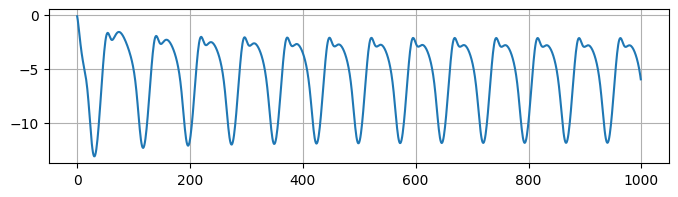

In [60]:
_, y1, y2, *_ = xt.T
figure(figsize=(8,2)); plot(y2-y1); grid(1); 

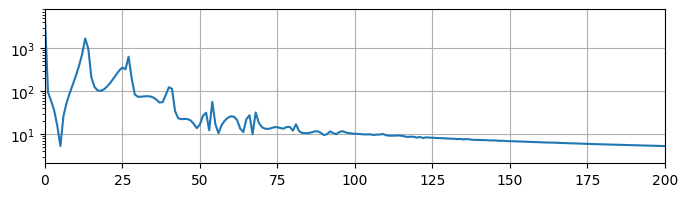

In [63]:
figure(figsize=(8,2)); semilogy(np.abs(np.fft.fft(y2-y1))); xlim([0,200]); grid(1);

## Stochasticity

In [66]:
def make_stochastic_heun_step(f, dt, sig):
    sig_sqrt_dt = sig*np.sqrt(dt)
    def step(x, z_t):
        noise = sig_sqrt_dt * z_t
        d1 = f(x)
        x1 = x + dt*d1 + noise
        d2 = f(x1)
        return x + dt*0.5*(d1 + d2) + noise
    return step

def make_noisy_loop(f):
    @jax.jit
    def loop(x0, zs):
        def op(x, z):
            x = step(x, z)
            return x, x
        return jax.lax.scan(op, x0, zs)[1]
    return loop

In [ ]:
dfun_ = make_jr_dfun()
dfun = lambda x: dfun_(x, 0.0)
step = make_stochastic_heun_step(
        dfun,
        dt=2.0,
        sig=1e-3)
loop = make_noisy_loop(step)

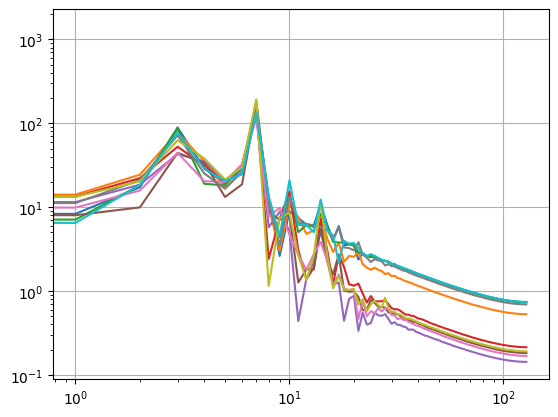

In [135]:
key = jax.random.PRNGKey(2)

for i in range(10):
    key = jax.random.PRNGKey(i)
    x0 = np.zeros(6)
    zs = jax.random.normal(key, (2048, ) + x0.shape) * 1e-2
    _, y1, y2, *_ = loop(x0, zs).T
    lfp = y1 - y2
    loglog((np.abs( np.mean(np.fft.rfft(lfp.reshape((8, 256)), axis=1), axis=0) )))
    grid(1)

The model shows characteristic spectra for a single parameter set.

## Long time series

How can we handle long time series with many time steps?

In [110]:
for nt in [256, 1024, 16384, 16384*32]:

    key = jax.random.PRNGKey(42)
    x0 = np.zeros(6)
    def pred(x0):
        zs = jax.random.normal(key, (nt, ) + x0.shape) * 1e-2
        _, y1, y2, *_ = loop(x0, zs).T
        lfp = y1 - y2
        slp = np.log(np.abs( np.mean(np.fft.rfft(lfp.reshape((-1, 256)), axis=1), axis=0) ))
        return slp
    slp = pred(x0)
    %timeit -n10 -r5 pred(x0)
    
    def loss(x0hat):
        return np.sum(np.square(slp - pred(x0hat)))
    gloss = jax.grad(loss)
    gloss(x0)
    %timeit -n10 -r5 gloss(x0)
    print()


1.16 ms ± 322 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
9.1 ms ± 714 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)

1.6 ms ± 219 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
14.6 ms ± 2.58 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)

7.9 ms ± 1.11 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
25.9 ms ± 1.91 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)

113 ms ± 6 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
178 ms ± 6.23 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)



That scales nicely for single simulations, but when we're evaluating log-p, we need to do it many times: a trick is to parallelize in time:

In [123]:
zs = jax.random.normal(key, (nt, ) + x0.shape) * 1e-2
yt = loop(x0, zs)

Assuming we take `yt` as our parameter to sample, so we just need to evaluate the expected next step in parallel:

In [133]:
step_mu = jax.jit(jax.vmap(lambda xs: step(xs, 0.0)))
print(step_mu(yt).shape)
%timeit step_mu(yt)

(524288, 6)
14.2 ms ± 787 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


this is automatically using ~300% cpu reflecting the parallel speed up over sequential iteration:

In [134]:
%timeit loop(x0, zs).T

54.4 ms ± 7.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We should expect this speedup to be more significant on a GPU.

Next steps 

- [ ] expand to a connectome
- [ ] test batch eval on a GPU
- [ ] use cases w/ MUSE: JR spectra, MPR FCD


## Switching parameter structures

It will be a nuisance to thread a bunch of parameters through all that code for fitting.   Jax knows how to handle basic data structures.  Let's make use of that:

In [4]:
# later switch to jax_dataclasses
from collections import namedtuple

JRp = namedtuple(typename='JRp',
                field_names='A B a b v0 nu_max r J a_1 a_2 a_3 a_4 mu I'.split(' '))
jr0 = JRp(A=3.25, B=22.0, a=0.1, b=0.05, v0=5.52, nu_max=0.0025, 
         r=0.56, J=135.0, a_1=1.0, a_2=0.8, a_3=0.25, a_4=0.25, mu=0.22, I=0.0)
jr0

JRp(A=3.25, B=22.0, a=0.1, b=0.05, v0=5.52, nu_max=0.0025, r=0.56, J=135.0, a_1=1.0, a_2=0.8, a_3=0.25, a_4=0.25, mu=0.22, I=0.0)

now we adapt the code above,

In [24]:
def dfun(ys, c, p):
    y0, y1, y2, y3, y4, y5 = ys

    sigm_y1_y2 = 2.0 * p.nu_max / (1.0 + np.exp(p.r * (p.v0 - (y1 - y2))))
    sigm_y0_1  = 2.0 * p.nu_max / (1.0 + np.exp(p.r * (p.v0 - (p.a_1 * p.J * y0))))
    sigm_y0_3  = 2.0 * p.nu_max / (1.0 + np.exp(p.r * (p.v0 - (p.a_3 * p.J * y0))))

    return np.vstack([y3,
        y4,
        y5,
        p.A * p.a * sigm_y1_y2 - 2.0 * p.a * y3 - p.a ** 2 * y0,
        p.A * p.a * (p.mu + p.a_2 * p.J * sigm_y0_1 + c)
            - 2.0 * p.a * y4 - p.a ** 2 * y1,
        p.B * p.b * (p.a_4 * p.J * sigm_y0_3) - 2.0 * p.b * y5 - p.b ** 2 * y2,
                     ])

dfun(np.zeros((6, 32)), 0, jr0).shape

(6, 32)

In [51]:
# TODO refactor to library, we don't need 10 copies of this floating
from nfjax.loops import make_sde

def net_dfun(x, p):
    # mean all to all coupling, no delays
    return dfun(x, 1e-2*np.mean(x[1] - x[2]), p)

step, loop = make_sde(1.0, net_dfun, 1e-1)

key = jax.random.PRNGKey(0)
nt = 10240
nn = 32
x0 = np.zeros((6, nn))
zt = jax.random.normal(key, (nt, ) + x0.shape) * 1e-2


yt = loop(x0, zt, jr0)
yt.shape

(10240, 6, 32)

In [52]:
%timeit loop(x0, zt, jr0)

6.16 ms ± 879 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


With this structure, it's much easier to construct a loss over parameters.